In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os
from PIL import Image
from tqdm import tqdm
import glob

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Any, List

# 해당 클래스가 우리 모델 AODnet_MultiBranch 실제 이름 TBaodNet
class AODnet_MultiBranch(nn.Module):
    def __init__(self):
        super(AODnet_MultiBranch, self).__init__()
        print("[Model] Multi-Branch AODNet 초기화 중 (3 독립 K 변수 모드)...")

        # ----- K_A Branch (예: 안개 제거, Dehazing) -----
        # K1 Branch 구조는 그대로 유지
        self.k1_conv1 = nn.Conv2d(3, 3, kernel_size=1)
        self.k1_conv2 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        self.k1_conv3 = nn.Conv2d(6, 3, kernel_size=5, padding=2) # 출력 채널: 3

        # ----- K_B Branch (예: 빗줄기 제거, Deraining) -----
        # K2 Branch 구조는 그대로 유지
        self.k2_conv1 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        self.k2_conv2 = nn.Conv2d(3, 3, kernel_size=5, padding=2)
        self.k2_conv3 = nn.Conv2d(6, 3, kernel_size=7, padding=3) # 출력 채널: 3
        
        # ----- K_C Branch (예: 물방울 제거, Raindrop Removal) -----
        # K3 Branch 구조는 그대로 유지
        self.k3_conv1 = nn.Conv2d(3, 3, kernel_size=5, padding=2)
        self.k3_conv2 = nn.Conv2d(3, 3, kernel_size=7, padding=3)
        self.k3_conv3 = nn.Conv2d(6, 3, kernel_size=9, padding=4) # 출력 채널: 3

        # 🚨 DBAODNet 방식 적용을 위해 'Fusion' 레이어 대신 '독립적인 K 출력' 레이어를 사용합니다.
        # K1, K2, K3 결과는 이미 각 브랜치의 k_conv3에서 3채널로 나옵니다.
        # 기존 Fusion_conv는 K_final을 만들기 위해 존재했으나, 이제 K1, K2, K3가 독립적인 K_A, K_B, K_C 역할을 합니다.
        # 따라서, 추가 Fusion 레이어 없이 K1, K2, K3의 결과(k1, k2, k3)를 그대로 K_A, K_B, K_C로 사용합니다.
        
        # self.fusion_conv = nn.Conv2d(9, 3, kernel_size=3, padding=1) # 🚨 제거

        print("[Model] Multi-Branch AODNet 초기화 완료\n")


    def forward(self, x):
        # --- K_A Branch (안개 제거) 연산 ---
        x1_1 = F.relu(self.k1_conv1(x))
        x1_2 = F.relu(self.k1_conv2(x1_1))
        k1_cat = torch.cat((x1_1, x1_2), dim=1)
        K_A = F.relu(self.k1_conv3(k1_cat)) # 🚨 K_A 변수 (Dehazing 정보)

        # --- K_B Branch (빗줄기 제거) 연산 ---
        x2_1 = F.relu(self.k2_conv1(x))
        x2_2 = F.relu(self.k2_conv2(x2_1))
        k2_cat = torch.cat((x2_1, x2_2), dim=1)
        K_B = F.relu(self.k2_conv3(k2_cat)) # 🚨 K_B 변수 (Deraining 정보)

        # --- K_C Branch (물방울 제거) 연산 ---
        x3_1 = F.relu(self.k3_conv1(x))
        x3_2 = F.relu(self.k3_conv2(x3_1))
        k3_cat = torch.cat((x3_1, x3_2), dim=1)
        K_C = F.relu(self.k3_conv3(k3_cat)) # 🚨 K_C 변수 (Raindrop 정보)

        # 🚨 DBAODNet 방식의 최종 복원 공식 적용 🚨
        # DBAODNet 확장 유도: J(x) = K_diff * I(x) - K_diff
        # K_diff = K_A - K_B - K_C (K_A를 주 복원 항, K_B/K_C를 차감/잔여 항으로 가정)
        
        k_diff = K_A - K_B - K_C  # 통합 K_diff 계산
        
        output = k_diff * x - k_diff # 최종 복원식 (상수항 없음)
        
        return F.relu(output)

In [3]:
def print_model_summary(model, model_name):
    """모델의 파라미터 정보와 총 개수를 출력하는 함수"""
    print(f"========== {model_name} Summary ==========")
    
    # 모델의 각 파라미터 이름과 크기(shape) 출력
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name},  Shape: {param.shape}")
    
    # 전체 파라미터 개수 계산 및 출력
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal trainable parameters: {total_params:,}")
    print("=" * (len(model_name) + 24))
    print("\n")


# 1. AODnet 모델 객체 생성 및 파라미터 확인
model = AODnet_MultiBranch()
print_model_summary(model, "AODnet")

[Model] Multi-Branch AODNet 초기화 중 (3 독립 K 변수 모드)...
[Model] Multi-Branch AODNet 초기화 완료

========== AODnet Summary ==========
Layer: k1_conv1.weight,  Shape: torch.Size([3, 3, 1, 1])
Layer: k1_conv1.bias,  Shape: torch.Size([3])
Layer: k1_conv2.weight,  Shape: torch.Size([3, 3, 3, 3])
Layer: k1_conv2.bias,  Shape: torch.Size([3])
Layer: k1_conv3.weight,  Shape: torch.Size([3, 6, 5, 5])
Layer: k1_conv3.bias,  Shape: torch.Size([3])
Layer: k2_conv1.weight,  Shape: torch.Size([3, 3, 3, 3])
Layer: k2_conv1.bias,  Shape: torch.Size([3])
Layer: k2_conv2.weight,  Shape: torch.Size([3, 3, 5, 5])
Layer: k2_conv2.bias,  Shape: torch.Size([3])
Layer: k2_conv3.weight,  Shape: torch.Size([3, 6, 7, 7])
Layer: k2_conv3.bias,  Shape: torch.Size([3])
Layer: k3_conv1.weight,  Shape: torch.Size([3, 3, 5, 5])
Layer: k3_conv1.bias,  Shape: torch.Size([3])
Layer: k3_conv2.weight,  Shape: torch.Size([3, 3, 7, 7])
Layer: k3_conv2.bias,  Shape: torch.Size([3])
Layer: k3_conv3.weight,  Shape: torch.Size([3, 6, 9

In [4]:
class DehazeDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        :param data_dir: train, test, val 폴더 중 하나의 경로 (예: 'dataset2_split/train')
        :param transform: 이미지에 적용할 torchvision.transforms
        """
        self.gt_dir = os.path.join(data_dir, 'gt')
        self.input_dir = os.path.join(data_dir, 'input')
        self.transform = transform
        
        # input 폴더의 파일 목록을 기준으로 삼음
        self.image_files = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        
        input_path = os.path.join(self.input_dir, filename)
        gt_path = os.path.join(self.gt_dir, filename)
        
        # PIL 라이브러리를 사용해 이미지 열기 (RGB 형식으로 변환)
        input_image = Image.open(input_path).convert('RGB')
        gt_image = Image.open(gt_path).convert('RGB')
        
        if self.transform:
            input_image = self.transform(input_image)
            gt_image = self.transform(gt_image)
            
        return input_image, gt_image

In [5]:
# GPU 사용 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# 하이퍼파라미터
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 100

# 데이터셋 경로 (split_dataset.py 실행 후 생성된 폴더)
DATA_DIR = "./dataset_split"
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

# 학습된 모델 가중치를 저장할 경로
MODEL_SAVE_PATH = "./pt/TBaodNet6"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

Using device: cuda


In [6]:
# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((240, 360)),
    transforms.ToTensor()
])

# 훈련 데이터셋 및 데이터 로더
train_dataset = DehazeDataset(data_dir=TRAIN_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# 검증 데이터셋 및 데이터 로더
val_dataset = DehazeDataset(data_dir=VAL_DIR, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"훈련 데이터셋 크기: {len(train_dataset)}개")
print(f"검증 데이터셋 크기: {len(val_dataset)}개")

# 셀 5 실행 후 이 코드를 실행해보세요
try:
    input_img, gt_img = train_dataset[0]
    print("데이터셋 로딩 성공!")
    print("Input 이미지 텐서 모양:", input_img.shape)
    print("GT 이미지 텐서 모양:", gt_img.shape)
except Exception as e:
    print("데이터셋 로딩 중 오류 발생:", e)

훈련 데이터셋 크기: 3543개
검증 데이터셋 크기: 507개
데이터셋 로딩 성공!
Input 이미지 텐서 모양: torch.Size([3, 240, 360])
GT 이미지 텐서 모양: torch.Size([3, 240, 360])


In [7]:
# 모델 인스턴스 생성 및 GPU로 이동
# model = AODnet().to(DEVICE) # 기본 모델을 사용하려면 이 줄의 주석을 해제
model = AODnet_MultiBranch().to(DEVICE) # PONO 모델 사용
print("Model:", model.__class__.__name__)

# 손실 함수 (Loss Function) - 이미지 복원에는 MSE Loss가 일반적으로 사용됨
criterion = nn.MSELoss()

# 옵티마이저 (Optimizer) - Adam이 안정적이고 좋은 성능을 보임
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

[Model] Multi-Branch AODNet 초기화 중 (3 독립 K 변수 모드)...
[Model] Multi-Branch AODNet 초기화 완료

Model: AODnet_MultiBranch


In [8]:
# 각 에폭의 손실 값을 저장할 리스트 생성
train_loss_history = [] # <<< 추가
val_loss_history = []   # <<< 추가

best_val_loss = float('inf')

print("\n===== 모델 학습을 시작합니다 =====")
for epoch in range(NUM_EPOCHS):
    # --- 훈련 단계 ---
    model.train()
    train_loss = 0.0
    
    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for hazy_images, clean_images in train_iterator:
        hazy_images = hazy_images.to(DEVICE)
        clean_images = clean_images.to(DEVICE)
        
        outputs = model(hazy_images)
        loss = criterion(outputs, clean_images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item()})
        
    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss) # <<< 추가

    # --- 검증 단계 ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for hazy_images, clean_images in val_iterator:
            hazy_images = hazy_images.to(DEVICE)
            clean_images = clean_images.to(DEVICE)
            
            outputs = model(hazy_images)
            loss = criterion(outputs, clean_images)
            val_loss += loss.item()
            val_iterator.set_postfix({'loss': loss.item()})
            
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss) # <<< 추가
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_file = os.path.join(MODEL_SAVE_PATH, f"best_model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), save_file)
        print(f"***** Best model saved to {save_file} (Val Loss: {best_val_loss:.6f}) *****\n")

print("\n===== 모든 학습이 완료되었습니다! =====")


===== 모델 학습을 시작합니다 =====


Epoch 1/100 [Val]: 100%|██████████| 32/32 [00:04<00:00,  7.32it/s, loss=0.165] 


Epoch [1/100], Train Loss: 0.153250, Val Loss: 0.117983
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_1.pth (Val Loss: 0.117983) *****



Epoch 2/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.20it/s, loss=0.144] 


Epoch [2/100], Train Loss: 0.106625, Val Loss: 0.103987
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_2.pth (Val Loss: 0.103987) *****



Epoch 3/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.26it/s, loss=0.132] 


Epoch [3/100], Train Loss: 0.097591, Val Loss: 0.096911
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_3.pth (Val Loss: 0.096911) *****



Epoch 4/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s, loss=0.123] 


Epoch [4/100], Train Loss: 0.091543, Val Loss: 0.090886
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_4.pth (Val Loss: 0.090886) *****



Epoch 5/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s, loss=0.118] 


Epoch [5/100], Train Loss: 0.085832, Val Loss: 0.086753
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_5.pth (Val Loss: 0.086753) *****



Epoch 6/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s, loss=0.112] 


Epoch [6/100], Train Loss: 0.082236, Val Loss: 0.083466
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_6.pth (Val Loss: 0.083466) *****



Epoch 7/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.22it/s, loss=0.11]  


Epoch [7/100], Train Loss: 0.080039, Val Loss: 0.081578
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_7.pth (Val Loss: 0.081578) *****



Epoch 8/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.13it/s, loss=0.105] 


Epoch [8/100], Train Loss: 0.077844, Val Loss: 0.079507
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_8.pth (Val Loss: 0.079507) *****



Epoch 9/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s, loss=0.103] 


Epoch [9/100], Train Loss: 0.076163, Val Loss: 0.077877
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_9.pth (Val Loss: 0.077877) *****



Epoch 10/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s, loss=0.102] 


Epoch [10/100], Train Loss: 0.074649, Val Loss: 0.076812
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_10.pth (Val Loss: 0.076812) *****



Epoch 11/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s, loss=0.097] 


Epoch [11/100], Train Loss: 0.073473, Val Loss: 0.075608
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_11.pth (Val Loss: 0.075608) *****



Epoch 12/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s, loss=0.0954]


Epoch [12/100], Train Loss: 0.072415, Val Loss: 0.074636
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_12.pth (Val Loss: 0.074636) *****



Epoch 13/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.32it/s, loss=0.0936]


Epoch [13/100], Train Loss: 0.071614, Val Loss: 0.073910
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_13.pth (Val Loss: 0.073910) *****



Epoch 14/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s, loss=0.0934]


Epoch [14/100], Train Loss: 0.070773, Val Loss: 0.073083
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_14.pth (Val Loss: 0.073083) *****



Epoch 15/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s, loss=0.0933]


Epoch [15/100], Train Loss: 0.070298, Val Loss: 0.072698
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_15.pth (Val Loss: 0.072698) *****



Epoch 16/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s, loss=0.0872]


Epoch [16/100], Train Loss: 0.069596, Val Loss: 0.072803


Epoch 17/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s, loss=0.0915]


Epoch [17/100], Train Loss: 0.068852, Val Loss: 0.071738
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_17.pth (Val Loss: 0.071738) *****



Epoch 18/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.15it/s, loss=0.0905]


Epoch [18/100], Train Loss: 0.068748, Val Loss: 0.071317
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_18.pth (Val Loss: 0.071317) *****



Epoch 19/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.28it/s, loss=0.0873]


Epoch [19/100], Train Loss: 0.067813, Val Loss: 0.070289
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_19.pth (Val Loss: 0.070289) *****



Epoch 20/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.29it/s, loss=0.0834]


Epoch [20/100], Train Loss: 0.067471, Val Loss: 0.069628
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_20.pth (Val Loss: 0.069628) *****



Epoch 21/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s, loss=0.0821]


Epoch [21/100], Train Loss: 0.066918, Val Loss: 0.069300
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_21.pth (Val Loss: 0.069300) *****



Epoch 22/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.19it/s, loss=0.0803]


Epoch [22/100], Train Loss: 0.066419, Val Loss: 0.069007
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_22.pth (Val Loss: 0.069007) *****



Epoch 23/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.27it/s, loss=0.083] 


Epoch [23/100], Train Loss: 0.066244, Val Loss: 0.068413
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_23.pth (Val Loss: 0.068413) *****



Epoch 24/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.20it/s, loss=0.0783]


Epoch [24/100], Train Loss: 0.065565, Val Loss: 0.068402
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_24.pth (Val Loss: 0.068402) *****



Epoch 25/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.11it/s, loss=0.0776]


Epoch [25/100], Train Loss: 0.065223, Val Loss: 0.067584
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_25.pth (Val Loss: 0.067584) *****



Epoch 26/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.28it/s, loss=0.0801]


Epoch [26/100], Train Loss: 0.064952, Val Loss: 0.067261
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_26.pth (Val Loss: 0.067261) *****



Epoch 27/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.25it/s, loss=0.077] 


Epoch [27/100], Train Loss: 0.064706, Val Loss: 0.066882
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_27.pth (Val Loss: 0.066882) *****



Epoch 28/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.27it/s, loss=0.0803]


Epoch [28/100], Train Loss: 0.064316, Val Loss: 0.067231


Epoch 29/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.99it/s, loss=0.0777]


Epoch [29/100], Train Loss: 0.063954, Val Loss: 0.066409
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_29.pth (Val Loss: 0.066409) *****



Epoch 30/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.17it/s, loss=0.0748]


Epoch [30/100], Train Loss: 0.063596, Val Loss: 0.065965
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_30.pth (Val Loss: 0.065965) *****



Epoch 31/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.22it/s, loss=0.0718]


Epoch [31/100], Train Loss: 0.063390, Val Loss: 0.067042


Epoch 32/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.08it/s, loss=0.0712]


Epoch [32/100], Train Loss: 0.063246, Val Loss: 0.065723
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_32.pth (Val Loss: 0.065723) *****



Epoch 33/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.26it/s, loss=0.0734]


Epoch [33/100], Train Loss: 0.062879, Val Loss: 0.064946
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_33.pth (Val Loss: 0.064946) *****



Epoch 34/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.24it/s, loss=0.0732]


Epoch [34/100], Train Loss: 0.062562, Val Loss: 0.064669
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_34.pth (Val Loss: 0.064669) *****



Epoch 35/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.20it/s, loss=0.0691]


Epoch [35/100], Train Loss: 0.062326, Val Loss: 0.065239


Epoch 36/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.22it/s, loss=0.0731]


Epoch [36/100], Train Loss: 0.062077, Val Loss: 0.064399
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_36.pth (Val Loss: 0.064399) *****



Epoch 37/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.08it/s, loss=0.0693]


Epoch [37/100], Train Loss: 0.061806, Val Loss: 0.063864
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_37.pth (Val Loss: 0.063864) *****



Epoch 38/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.22it/s, loss=0.0723]


Epoch [38/100], Train Loss: 0.061545, Val Loss: 0.063875


Epoch 39/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.23it/s, loss=0.0684]


Epoch [39/100], Train Loss: 0.061303, Val Loss: 0.063633
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_39.pth (Val Loss: 0.063633) *****



Epoch 40/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.28it/s, loss=0.068] 


Epoch [40/100], Train Loss: 0.061084, Val Loss: 0.063359
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_40.pth (Val Loss: 0.063359) *****



Epoch 41/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.19it/s, loss=0.0736]


Epoch [41/100], Train Loss: 0.060820, Val Loss: 0.064219


Epoch 42/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.09it/s, loss=0.0666]


Epoch [42/100], Train Loss: 0.060693, Val Loss: 0.062799
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_42.pth (Val Loss: 0.062799) *****



Epoch 43/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.40it/s, loss=0.0683]


Epoch [43/100], Train Loss: 0.060405, Val Loss: 0.062467
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_43.pth (Val Loss: 0.062467) *****



Epoch 44/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.42it/s, loss=0.0693]


Epoch [44/100], Train Loss: 0.060343, Val Loss: 0.062808


Epoch 45/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.40it/s, loss=0.0669]


Epoch [45/100], Train Loss: 0.060212, Val Loss: 0.062171
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_45.pth (Val Loss: 0.062171) *****



Epoch 46/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.43it/s, loss=0.0666]


Epoch [46/100], Train Loss: 0.060158, Val Loss: 0.062001
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_46.pth (Val Loss: 0.062001) *****



Epoch 47/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.29it/s, loss=0.0665]


Epoch [47/100], Train Loss: 0.059745, Val Loss: 0.061723
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_47.pth (Val Loss: 0.061723) *****



Epoch 48/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.42it/s, loss=0.0655]


Epoch [48/100], Train Loss: 0.059375, Val Loss: 0.061514
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_48.pth (Val Loss: 0.061514) *****



Epoch 49/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.51it/s, loss=0.0651]


Epoch [49/100], Train Loss: 0.059315, Val Loss: 0.061455
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_49.pth (Val Loss: 0.061455) *****



Epoch 50/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.44it/s, loss=0.0685]


Epoch [50/100], Train Loss: 0.059345, Val Loss: 0.061949


Epoch 51/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.55it/s, loss=0.0658]


Epoch [51/100], Train Loss: 0.059166, Val Loss: 0.061169
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_51.pth (Val Loss: 0.061169) *****



Epoch 52/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.36it/s, loss=0.0662]


Epoch [52/100], Train Loss: 0.058817, Val Loss: 0.061409


Epoch 53/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.35it/s, loss=0.0631]


Epoch [53/100], Train Loss: 0.058609, Val Loss: 0.060648
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_53.pth (Val Loss: 0.060648) *****



Epoch 54/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.48it/s, loss=0.0622]


Epoch [54/100], Train Loss: 0.058337, Val Loss: 0.060835


Epoch 55/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.46it/s, loss=0.0625]


Epoch [55/100], Train Loss: 0.058288, Val Loss: 0.060295
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_55.pth (Val Loss: 0.060295) *****



Epoch 56/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.48it/s, loss=0.0639]


Epoch [56/100], Train Loss: 0.058133, Val Loss: 0.060275
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_56.pth (Val Loss: 0.060275) *****



Epoch 57/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.43it/s, loss=0.0637]


Epoch [57/100], Train Loss: 0.057748, Val Loss: 0.060175
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_57.pth (Val Loss: 0.060175) *****



Epoch 58/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.47it/s, loss=0.0608]


Epoch [58/100], Train Loss: 0.057628, Val Loss: 0.059585
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_58.pth (Val Loss: 0.059585) *****



Epoch 59/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.38it/s, loss=0.0602]


Epoch [59/100], Train Loss: 0.057379, Val Loss: 0.059800


Epoch 60/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.41it/s, loss=0.0624]


Epoch [60/100], Train Loss: 0.057414, Val Loss: 0.059450
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_60.pth (Val Loss: 0.059450) *****



Epoch 61/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.47it/s, loss=0.0592]


Epoch [61/100], Train Loss: 0.057455, Val Loss: 0.059763


Epoch 62/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.45it/s, loss=0.0592]


Epoch [62/100], Train Loss: 0.056999, Val Loss: 0.059725


Epoch 63/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.52it/s, loss=0.059] 


Epoch [63/100], Train Loss: 0.056905, Val Loss: 0.059399
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_63.pth (Val Loss: 0.059399) *****



Epoch 64/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.50it/s, loss=0.0603]


Epoch [64/100], Train Loss: 0.056650, Val Loss: 0.058922
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_64.pth (Val Loss: 0.058922) *****



Epoch 65/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.40it/s, loss=0.0608]


Epoch [65/100], Train Loss: 0.056490, Val Loss: 0.058623
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_65.pth (Val Loss: 0.058623) *****



Epoch 66/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.43it/s, loss=0.0585]


Epoch [66/100], Train Loss: 0.056363, Val Loss: 0.058581
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_66.pth (Val Loss: 0.058581) *****



Epoch 67/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.48it/s, loss=0.0601]


Epoch [67/100], Train Loss: 0.056379, Val Loss: 0.058209
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_67.pth (Val Loss: 0.058209) *****



Epoch 68/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.40it/s, loss=0.0584]


Epoch [68/100], Train Loss: 0.056237, Val Loss: 0.058498


Epoch 69/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.45it/s, loss=0.058] 


Epoch [69/100], Train Loss: 0.055928, Val Loss: 0.058248


Epoch 70/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.39it/s, loss=0.0613]


Epoch [70/100], Train Loss: 0.055710, Val Loss: 0.058577


Epoch 71/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.38it/s, loss=0.06]  


Epoch [71/100], Train Loss: 0.055735, Val Loss: 0.057909
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_71.pth (Val Loss: 0.057909) *****



Epoch 72/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  8.93it/s, loss=0.0589]


Epoch [72/100], Train Loss: 0.055694, Val Loss: 0.057618
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_72.pth (Val Loss: 0.057618) *****



Epoch 73/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.17it/s, loss=0.0585]


Epoch [73/100], Train Loss: 0.055575, Val Loss: 0.057434
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_73.pth (Val Loss: 0.057434) *****



Epoch 74/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.19it/s, loss=0.0592]


Epoch [74/100], Train Loss: 0.055529, Val Loss: 0.057442


Epoch 75/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.18it/s, loss=0.0629]


Epoch [75/100], Train Loss: 0.055400, Val Loss: 0.058687


Epoch 76/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.19it/s, loss=0.0577]


Epoch [76/100], Train Loss: 0.055162, Val Loss: 0.057061
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_76.pth (Val Loss: 0.057061) *****



Epoch 77/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.12it/s, loss=0.0581]


Epoch [77/100], Train Loss: 0.055063, Val Loss: 0.056998
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_77.pth (Val Loss: 0.056998) *****



Epoch 78/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.18it/s, loss=0.0619]


Epoch [78/100], Train Loss: 0.054909, Val Loss: 0.058125


Epoch 79/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s, loss=0.0563]


Epoch [79/100], Train Loss: 0.054819, Val Loss: 0.056905
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_79.pth (Val Loss: 0.056905) *****



Epoch 80/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.74it/s, loss=0.0573]


Epoch [80/100], Train Loss: 0.054854, Val Loss: 0.056623
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_80.pth (Val Loss: 0.056623) *****



Epoch 81/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.11it/s, loss=0.0585]


Epoch [81/100], Train Loss: 0.054680, Val Loss: 0.056767


Epoch 82/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.02it/s, loss=0.0563]


Epoch [82/100], Train Loss: 0.054385, Val Loss: 0.056648


Epoch 83/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.39it/s, loss=0.0579]


Epoch [83/100], Train Loss: 0.054352, Val Loss: 0.056755


Epoch 84/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.39it/s, loss=0.0559]


Epoch [84/100], Train Loss: 0.054214, Val Loss: 0.056235
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_84.pth (Val Loss: 0.056235) *****



Epoch 85/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.46it/s, loss=0.0557]


Epoch [85/100], Train Loss: 0.054142, Val Loss: 0.056042
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_85.pth (Val Loss: 0.056042) *****



Epoch 86/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.29it/s, loss=0.0559]


Epoch [86/100], Train Loss: 0.054110, Val Loss: 0.058152


Epoch 87/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.17it/s, loss=0.0565]


Epoch [87/100], Train Loss: 0.053986, Val Loss: 0.055934
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_87.pth (Val Loss: 0.055934) *****



Epoch 88/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.44it/s, loss=0.0581]


Epoch [88/100], Train Loss: 0.053851, Val Loss: 0.056341


Epoch 89/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.53it/s, loss=0.0548]


Epoch [89/100], Train Loss: 0.053524, Val Loss: 0.055846
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_89.pth (Val Loss: 0.055846) *****



Epoch 90/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.48it/s, loss=0.0573]


Epoch [90/100], Train Loss: 0.053708, Val Loss: 0.055870


Epoch 91/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.49it/s, loss=0.055] 


Epoch [91/100], Train Loss: 0.053574, Val Loss: 0.055700
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_91.pth (Val Loss: 0.055700) *****



Epoch 92/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.55it/s, loss=0.0559]


Epoch [92/100], Train Loss: 0.053544, Val Loss: 0.055519
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_92.pth (Val Loss: 0.055519) *****



Epoch 93/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.57it/s, loss=0.056] 


Epoch [93/100], Train Loss: 0.053279, Val Loss: 0.055452
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_93.pth (Val Loss: 0.055452) *****



Epoch 94/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.49it/s, loss=0.054] 


Epoch [94/100], Train Loss: 0.053229, Val Loss: 0.055620


Epoch 95/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.49it/s, loss=0.0559]


Epoch [95/100], Train Loss: 0.053433, Val Loss: 0.055263
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_95.pth (Val Loss: 0.055263) *****



Epoch 96/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.21it/s, loss=0.0536]


Epoch [96/100], Train Loss: 0.053103, Val Loss: 0.056826


Epoch 97/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.50it/s, loss=0.056] 


Epoch [97/100], Train Loss: 0.052963, Val Loss: 0.055392


Epoch 98/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.52it/s, loss=0.0589]


Epoch [98/100], Train Loss: 0.053085, Val Loss: 0.056054


Epoch 99/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.49it/s, loss=0.0548]


Epoch [99/100], Train Loss: 0.052812, Val Loss: 0.055423


Epoch 100/100 [Val]: 100%|██████████| 32/32 [00:03<00:00,  9.05it/s, loss=0.0555]

Epoch [100/100], Train Loss: 0.052810, Val Loss: 0.054968
***** Best model saved to ./pt/TBaodNet6\best_model_epoch_100.pth (Val Loss: 0.054968) *****


===== 모든 학습이 완료되었습니다! =====


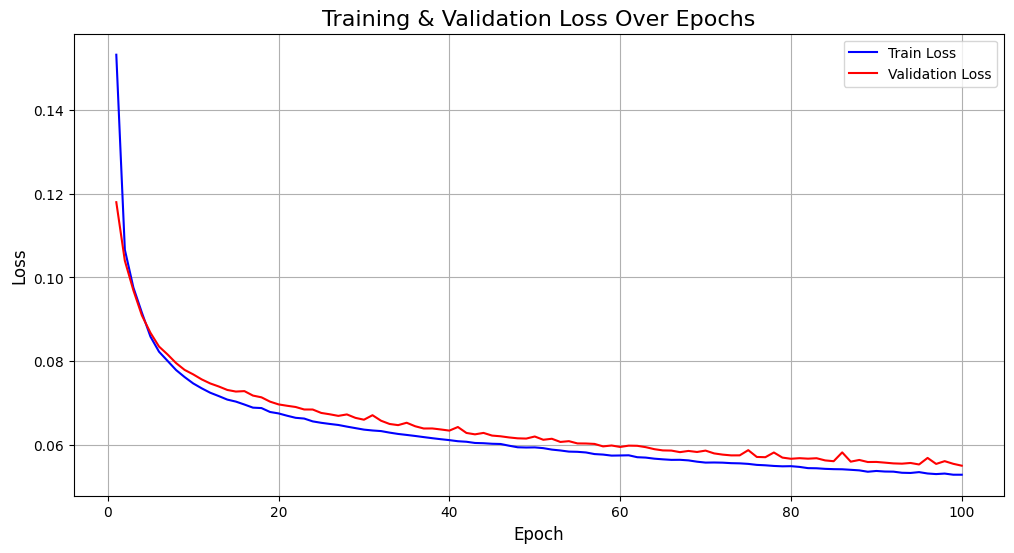

In [9]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 훈련 손실과 검증 손실 그래프 그리기
plt.plot(range(1, NUM_EPOCHS + 1), train_loss_history, label='Train Loss', color='blue')
plt.plot(range(1, NUM_EPOCHS + 1), val_loss_history, label='Validation Loss', color='red')

# 그래프 제목 및 축 레이블 설정
plt.title('Training & Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# 범례 표시
plt.legend()

# 그리드 표시
plt.grid(True)

# 그래프 보여주기
plt.show()

In [10]:
# 새로운 셀

import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 평가에 사용할 테스트셋 폴더 경로
TEST_DIR = os.path.join(DATA_DIR, 'test')

# 2. 불러올 학습된 모델 가중치 파일의 경로
# 'trained_models' 폴더 안에 저장된 .pth 파일 중 가장 성능이 좋았던(best) 모델의 경로를 지정합니다.
MODEL_WEIGHTS_PATH = "pt/TBaodNet6/best_model_epoch_100.pth" # XX 부분은 실제 파일 숫자로 변경
# --------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = AODnet_MultiBranch().to(DEVICE)
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval() # 모델을 반드시 평가 모드로 설정!

# 테스트 데이터 로더 준비
test_dataset = DehazeDataset(data_dir=TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0) # num_workers=0으로 설정

# 점수를 저장할 리스트 초기화
psnr_scores = []
ssim_scores = []

print(f"\n===== '{MODEL_WEIGHTS_PATH}' 모델 성능 평가 시작 =====")

# 평가 루프
with torch.no_grad(): # 기울기 계산 비활성화
    for hazy_images, clean_images in tqdm(test_loader, desc="Evaluating"):
        hazy_images = hazy_images.to(DEVICE)
        
        # 모델 추론
        outputs = evaluation_model(hazy_images)
        
        # GPU 텐서를 CPU의 Numpy 배열로 변환 (skimage 계산용)
        # (B, C, H, W) -> (B, H, W, C) 형태로 변경 및 0-255 범위의 정수형으로 변환
        outputs_np = outputs.cpu().permute(0, 2, 3, 1).numpy() * 255
        clean_images_np = clean_images.cpu().permute(0, 2, 3, 1).numpy() * 255
        
        outputs_np = outputs_np.astype(np.uint8)
        clean_images_np = clean_images_np.astype(np.uint8)
        
        # 배치 내의 각 이미지에 대해 점수 계산
        for i in range(clean_images_np.shape[0]):
            gt_image = clean_images_np[i]
            pred_image = outputs_np[i]
            
            # PSNR 계산
            psnr = peak_signal_noise_ratio(gt_image, pred_image, data_range=255)
            psnr_scores.append(psnr)
            
            # SSIM 계산
            # channel_axis=-1 은 컬러 이미지(RGB)의 채널 축을 지정해줍니다.
            ssim = structural_similarity(gt_image, pred_image, channel_axis=-1, data_range=255)
            ssim_scores.append(ssim)

# 평균 점수 계산
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)

print("\n===== 평가 완료 =====")
print(f"테스트 데이터셋 평균 PSNR: {avg_psnr:.4f} dB")
print(f"테스트 데이터셋 평균 SSIM: {avg_ssim:.4f}")

[Model] Multi-Branch AODNet 초기화 중 (3 독립 K 변수 모드)...
[Model] Multi-Branch AODNet 초기화 완료


===== 'pt/TBaodNet6/best_model_epoch_100.pth' 모델 성능 평가 시작 =====


Evaluating: 100%|██████████| 127/127 [00:20<00:00,  6.18it/s]


===== 평가 완료 =====
테스트 데이터셋 평균 PSNR: 13.6318 dB
테스트 데이터셋 평균 SSIM: 0.4738


In [12]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import os

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 불러올 학습된 모델 가중치 파일의 경로
MODEL_WEIGHTS_PATH = "pt/TBaodNet5/best_model_epoch_100.pth"

# 2. 복원할 안개 이미지(input) 파일 경로들을 리스트 형태로 지정
HAZY_IMAGE_PATHS = [
    "dataset_split/test/input/51_rain.png",
    "dataset_split/test/input/im_0048_s95_a06.png",
    "dataset_split/test/input/NYU2_1331.jpg"
]

# 3. 정답 이미지(gt)가 들어있는 폴더 경로
GT_BASE_DIR = "dataset_split/test/gt"

# 4. 모델 학습 시 사용했던 이미지 해상도
TARGET_IMAGE_SIZE = (240, 360)
# ----------------------------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = AODnet_MultiBranch().to(DEVICE) # DEVICE는 이전 셀에서 정의됨
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval()

# 이미지 전처리 transform 정의
transform = transforms.Compose([
    transforms.Resize(TARGET_IMAGE_SIZE),
    transforms.ToTensor()
])

# 결과를 저장할 리스트 생성
hazy_images_pil = []
restored_images_pil = []
clean_images_pil = []

print("이미지 복원을 시작합니다...")

for hazy_path in HAZY_IMAGE_PATHS:
    try:
        filename = os.path.basename(hazy_path)
        
        # ★★★ 수정된 부분 ★★★
        # os.path.join으로 생성된 경로를 os.path.normpath로 정규화
        clean_path_raw = os.path.join(GT_BASE_DIR, filename)
        clean_path = os.path.normpath(clean_path_raw)
        
        if not os.path.exists(clean_path):
            print(f"경고: 짝이 되는 정답 이미지 '{clean_path}'를 찾을 수 없습니다. 건너뜁니다.")
            continue

        hazy_image = Image.open(hazy_path).convert('RGB')
        clean_image = Image.open(clean_path).convert('RGB')
        
        hazy_tensor = transform(hazy_image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            restored_tensor = evaluation_model(hazy_tensor)

        restored_image = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())

        hazy_images_pil.append(hazy_image)
        restored_images_pil.append(restored_image)
        clean_images_pil.append(clean_image)
        print(f"'{hazy_path}' 복원 및 정답 이미지 로드 완료.")

    except FileNotFoundError:
        print(f"오류: '{hazy_path}' 파일을 찾을 수 없습니다. 경로를 다시 확인해주세요.")
    except Exception as e:
        print(f"'{hazy_path}' 처리 중 오류 발생: {e}")

# --- 시각화 부분 ---
if hazy_images_pil:
    num_images = len(hazy_images_pil)
    # 3개의 행(이미지 쌍), 3개의 열(Input, Restored, GT)
    plt.figure(figsize=(18, 5 * num_images)) 

    for i in range(num_images):
        # --- i번째 이미지 쌍 ---
        
        # 1열: 입력(Hazy) 이미지
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(hazy_images_pil[i])
        plt.title(f'Input (Hazy) #{i+1}')
        plt.axis('off')

        # 2열: 복원된 이미지
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(restored_images_pil[i])
        plt.title(f'Restored #{i+1}')
        plt.axis('off')
        
        # 3열: 정답(GT) 이미지
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(clean_images_pil[i])
        plt.title(f'Ground Truth #{i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    print("\n이미지 복원 및 비교 완료!")

[Model] Multi-Branch AODNet 초기화 중 (3 독립 K 변수 모드)...
[Model] Multi-Branch AODNet 초기화 완료



RuntimeError: Error(s) in loading state_dict for AODnet_MultiBranch:
	Unexpected key(s) in state_dict: "fusion_conv.weight", "fusion_conv.bias". 
	size mismatch for k1_conv1.weight: copying a param with shape torch.Size([2, 3, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 3, 1, 1]).
	size mismatch for k1_conv1.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for k1_conv2.weight: copying a param with shape torch.Size([2, 2, 3, 3]) from checkpoint, the shape in current model is torch.Size([3, 3, 3, 3]).
	size mismatch for k1_conv2.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for k1_conv3.weight: copying a param with shape torch.Size([2, 4, 5, 5]) from checkpoint, the shape in current model is torch.Size([3, 6, 5, 5]).
	size mismatch for k1_conv3.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for k2_conv1.weight: copying a param with shape torch.Size([2, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([3, 3, 3, 3]).
	size mismatch for k2_conv1.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for k2_conv2.weight: copying a param with shape torch.Size([2, 2, 5, 5]) from checkpoint, the shape in current model is torch.Size([3, 3, 5, 5]).
	size mismatch for k2_conv2.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for k2_conv3.weight: copying a param with shape torch.Size([2, 4, 7, 7]) from checkpoint, the shape in current model is torch.Size([3, 6, 7, 7]).
	size mismatch for k2_conv3.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for k3_conv1.weight: copying a param with shape torch.Size([2, 3, 5, 5]) from checkpoint, the shape in current model is torch.Size([3, 3, 5, 5]).
	size mismatch for k3_conv1.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for k3_conv2.weight: copying a param with shape torch.Size([2, 2, 7, 7]) from checkpoint, the shape in current model is torch.Size([3, 3, 7, 7]).
	size mismatch for k3_conv2.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for k3_conv3.weight: copying a param with shape torch.Size([2, 4, 9, 9]) from checkpoint, the shape in current model is torch.Size([3, 6, 9, 9]).
	size mismatch for k3_conv3.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([3]).

In [18]:
# onnx 변환용 셀
# pth_to_onnx.py
import torch

# 1. 모델 구조 불러오기 및 가중치 로드
model = AODnet_MultiBranch_Light()
model.load_state_dict(torch.load('./pt/TBaodNet5/best_model_epoch_100.pth', map_location='cpu'))
model.eval() # 반드시 evaluation 모드로 설정!

# 2. 모델에 입력될 더미 데이터 생성 (중요!)
# 모델이 학습할 때 사용한 이미지 크기와 동일하게 맞춰주세요.
# 예: (배치크기, 채널, 높이, 너비)
dummy_input = torch.randn(1, 3, 240, 360) 

# 3. ONNX 파일로 변환
onnx_file_path = "aodnet5.onnx"
torch.onnx.export(model,
                  dummy_input,
                  onnx_file_path,
                  export_params=True,
                  opset_version=11, # 호환성을 위해 버전을 명시하는 것이 좋음
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'])

print(f"모델이 {onnx_file_path} 파일로 성공적으로 변환되었습니다.")

[Model] 경량화된 Multi-Branch AODNet (채널 축소) 초기화 중...
[Model] 경량화 모델 초기화 완료

모델이 aodnet5.onnx 파일로 성공적으로 변환되었습니다.


In [1]:
# TFLite 변환용 셀

# 1. 필요 라이브러리 설치 (최초 1회만 실행)
# !pip install onnx onnx-tf tensorflow

import tensorflow as tf
import onnx
from onnx_tf.backend import prepare
import numpy as np
import os

# --- 설정 ---
onnx_file_path = "aodnet5.onnx"
saved_model_dir = "C:/temp/aodnet_tf_model"
quantized_tflite_path = "aodnet5_quant_int8.tflite"


# 2. ONNX 모델을 TensorFlow SavedModel 형식으로 변환 (TFLite 변환을 위한 중간 단계)
print("ONNX 모델을 TensorFlow SavedModel로 변환하는 중...")
onnx_model = onnx.load(onnx_file_path)
tf_rep = prepare(onnx_model)
tf_rep.export_graph(saved_model_dir)
print(f"모델이 '{saved_model_dir}' 폴더에 저장되었습니다.")


# 3. 대표 데이터셋 준비 (가장 중요!)
# 모델의 가중치를 float32에서 int8로 변환할 때, 어떤 값 범위를 기준으로 삼을지 알려주는 샘플 데이터입니다.
# 실제 모델에 입력될 이미지와 유사한 데이터 100~200개를 사용하면 정확도가 높아집니다.
def representative_data_gen():
  print("대표 데이터셋 생성 중...")
  # 참고: 여기서는 랜덤 데이터를 생성했지만, 실제로는 학습에 사용했던 데이터나
  # 라즈베리파이에서 촬영될 이미지와 비슷한 샘플 이미지들을 전처리해서 사용해야 합니다.
  for _ in range(100):
    # PyTorch 모델의 입력 형식과 동일하게 (배치, 채널, 높이, 너비) 순서로 생성
    dummy_input = np.random.rand(1, 3, 240, 360).astype(np.float32)
    yield [dummy_input]
  print("대표 데이터셋 생성 완료.")


# 4. TFLite 변환기 설정 및 정수 양자화
print("TFLite 변환 및 정수 양자화 시작...")
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# 모든 연산을 INT8로 강제하여 최대 성능 확보 (호환성 문제가 발생하면 이 줄을 주석 처리)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# 5. 모델 변환 및 저장
tflite_quant_model = converter.convert()

with open(quantized_tflite_path, 'wb') as f:
  f.write(tflite_quant_model)

print("-" * 50)
print(f"✅ 정수 양자화된 모델 '{quantized_tflite_path}'이 성공적으로 저장되었습니다.")
print(f"이 파일을 라즈베리파이로 옮겨서 테스트하세요!")
print("-" * 50)

c:\Users\zmffk\OneDrive\바탕 화면\model\new-tf-env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\zmffk\OneDrive\바탕 화면\model\new-tf-env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do no

ONNX 모델을 TensorFlow SavedModel로 변환하는 중...
INFO:tensorflow:Assets written to: C:/temp/aodnet_tf_model\assets


INFO:tensorflow:Assets written to: C:/temp/aodnet_tf_model\assets


모델이 'C:/temp/aodnet_tf_model' 폴더에 저장되었습니다.
TFLite 변환 및 정수 양자화 시작...
대표 데이터셋 생성 중...
대표 데이터셋 생성 완료.
--------------------------------------------------
✅ 정수 양자화된 모델 'aodnet5_quant_int8.tflite'이 성공적으로 저장되었습니다.
이 파일을 라즈베리파이로 옮겨서 테스트하세요!
--------------------------------------------------


In [ ]:
#!/usr/bin/python3
import cv2
import numpy as np
import time
from picamera2 import Picamera2
from tensorflow.lite.python.interpreter import Interpreter

# --- 설정 ---
MODEL_PATH = 'aodnet5_quant_int8.tflite'
# ★ 모델의 입력 크기에 맞게 너비(WIDTH)와 높이(HEIGHT) 순서를 확인하고 수정합니다.
# 모델 입력이 (1, 3, 240, 360) 이므로 높이(H)=240, 너비(W)=360 입니다.
WIDTH, HEIGHT = 360, 240

def main():
    # --- 1. TFLite 모델 로드 ---
    try:
        interpreter = Interpreter(model_path=MODEL_PATH, num_threads=4)
        interpreter.allocate_tensors()
        
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        model_input_shape = input_details[0]['shape']
        print(f"모델이 요구하는 실제 입력 형태: {model_input_shape}")

        # ⭐️ 모델의 입력 데이터 타입이 INT8인지 확인합니다.
        is_int8_model = (input_details[0]['dtype'] == np.int8)
        
        if is_int8_model:
            print("INFO: 모델이 int8 입력을 사용합니다. 정수형으로 변환합니다.")
            # ⭐️ INT8 변환에 필요한 스케일과 제로 포인트를 미리 가져옵니다.
            input_quant_params = input_details[0]['quantization_parameters']
            input_scale = input_quant_params['scales'][0]
            input_zero_point = input_quant_params['zero_points'][0]
            
            output_quant_params = output_details[0]['quantization_parameters']
            output_scale = output_quant_params['scales'][0]
            output_zero_point = output_quant_params['zero_points'][0]
        else:
            print("INFO: 모델이 float32 입력을 사용합니다. 실수형으로 처리합니다.")

    except Exception as e:
        print(f"모델 로딩에 실패했습니다: {e}")
        return

    # --- 2. 카메라 설정 ---
    picam2 = Picamera2()
    config = picam2.create_preview_configuration(
        main={"size": (WIDTH, HEIGHT), "format": "RGB888"}
    )
    picam2.configure(config)
    picam2.start()
    time.sleep(1)
    print("카메라가 시작되었습니다.")

    fps_counter = 0
    start_time = time.time()

    try:
        while True:
            frame_original = picam2.capture_array()
            # 프레임 회전이 필요하다면 아래 코드의 주석을 해제하세요.
            frame = cv2.rotate(frame_original, cv2.ROTATE_180) 
            # frame = frame_original # 회전이 필요 없다면 이 줄을 사용

            # --- 3. 입력 데이터 전처리 ---
            # 모델의 입력 형태 (1, C, H, W)에서 높이와 너비를 가져옵니다.
            _, _, model_height, model_width = model_input_shape
            input_image = cv2.resize(frame, (model_width, model_height))
            
            # 배치 차원 추가 (H, W, C) -> (1, H, W, C)
            input_data = np.expand_dims(input_image, axis=0)
            
            # ⭐️ INT8 모델을 위한 데이터 양자화 (가장 중요한 부분)
            if is_int8_model:
                # uint8 (0~255) -> float32 (0.0~1.0)
                input_data_float = input_data.astype(np.float32) / 255.0
                # float32 (0.0~1.0) -> int8 (-128~127)
                input_data = (input_data_float / input_scale + input_zero_point).astype(np.int8)
            else: # float32 모델의 경우
                input_data = (input_data.astype(np.float32) / 255.0)

            # TensorFlow(NHWC) -> ONNX/PyTorch(NCHW) 순서로 변경
            # (1, H, W, C) -> (1, C, H, W)
            input_data = np.transpose(input_data, (0, 3, 1, 2))

            # --- 4. 모델 추론 ---
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])

            # --- 5. 출력 데이터 후처리 ---
            # ONNX/PyTorch(NCHW) -> TensorFlow(NHWC) 순서로 변경
            # (1, C, H, W) -> (1, H, W, C)
            output_data_nhwc = np.transpose(output_data, (0, 2, 3, 1))
            
            # ⭐️ INT8 모델의 출력값을 이미지로 변환 (역양자화)
            if is_int8_model:
                # int8 (-128~127) -> float32 (0.0~1.0)
                output_data_float = (output_data_nhwc.astype(np.float32) - output_zero_point) * output_scale
                # float32 -> uint8 (0~255)
                processed_image = np.clip(output_data_float[0] * 255.0, 0, 255).astype(np.uint8)
            else: # float32 모델의 경우
                processed_image = (output_data_nhwc[0] * 255.0).astype(np.uint8)
            
            # --- 6. 결과 출력 ---
            processed_bgr = cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR)
            cv2.imshow('Processed by TFLite', processed_bgr)

            fps_counter += 1
            if time.time() - start_time >= 1:
                print(f"FPS: {fps_counter}")
                fps_counter = 0
                start_time = time.time()
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
    finally:
        print("프로그램을 종료합니다.")
        picam2.stop()
        cv2.destroyAllWindows()

if __name__ == '__main__':
    main()